# Predictive Modeling with XGBoost

[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://githubtocolab.com/snowport/snowport.github.io/blob/main/docs/notebooks/mitxpro/05_XGBoost.ipynb)

## Introduction

An end-to-end workflow using NumPy, Pandas, Matplotlib, and XGBoost to evaluate model performance with ROC AUC, accuracy, and regression metrics.

## Module Import

In [ ]:
!pip install xgboost==1.6.1

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from datetime import datetime
import xgboost
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import auc
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score


import warnings

warnings.simplefilter(action="ignore", category=UserWarning)

## Dataset Import

Using the LendingClub loans dataset.

In [3]:
url = "https://docs.google.com/spreadsheets/d/10L8BpkV4q1Zsou4daYoWul_8PFA9rsv2/export?format=csv&id=10L8BpkV4q1Zsou4daYoWul_8PFA9rsv2&gid=1710894028"
df = pd.read_csv(url, index_col=False)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9516 entries, 0 to 9515
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   default      9516 non-null   int64  
 1   installment  9516 non-null   int64  
 2   log_income   9516 non-null   float64
 3   fico_score   9516 non-null   int64  
 4   rev_balance  9516 non-null   float64
 5   inquiries    9516 non-null   int64  
 6   records      9516 non-null   int64  
dtypes: float64(2), int64(5)
memory usage: 520.5 KB


In [5]:
df.head(6)

,default,installment,log_income,fico_score,rev_balance,inquiries,records
0,0,829,4.93,737,28.85,0,0
1,0,228,4.81,707,33.62,0,0
2,0,367,4.51,682,3.51,1,0
3,0,162,4.93,712,33.67,1,0
4,0,103,4.91,667,4.74,0,0
5,0,125,5.17,727,50.81,0,0


In [6]:
df.default.value_counts(normalize=True)

,proportion
default,
0,0.840164
1,0.159836


## Training and Test Datasets

Let's split the data 70/30 into a training set (which we will use to build models) and a test set (on which we will evaluate any model we build).

In [7]:
X = df.drop(["default"], axis=1)
y = df["default"]


# Encode string class values as integers to avoid errors in newer versions of XGBoost
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
label_encoder = label_encoder.fit(y)
y = label_encoder.transform(y)


# Splitting data into training and test set:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=7)
eval_set = [(X_test, y_test)]
print(X_train.shape, X_test.shape)

(6661, 6) (2855, 6)


In [8]:
print("Initializing xgboost.sklearn.XGBClassifier and starting training...")

st = datetime.now()

clf = xgboost.sklearn.XGBClassifier(
    objective="binary:logistic",
    learning_rate=0.05,
    seed=9616,
    max_depth=20,
    gamma=10,
    n_estimators=500,
)


clf.fit(
    X_train,
    y_train,
    eval_set=eval_set,
    eval_metric="auc",
    early_stopping_rounds=20,
    verbose=False,
)

print(f"Training time: {datetime.now() - st}")

# Make predictions
y_pred = clf.predict(X_test)

print(datetime.now() - st)

accuracy = accuracy_score(np.array(y_test).flatten(), y_pred)
print("Accuracy: %.10f%%" % (accuracy * 100.0))

accuracy_per_roc_auc = roc_auc_score(np.array(y_test).flatten(), y_pred)
print("ROC-AUC: %.10f%%" % (accuracy_per_roc_auc * 100))

Initializing xgboost.sklearn.XGBClassifier and starting training...
Training time: 0:00:07.489654
0:00:07.497859
Accuracy: 83.4325744308%
ROC-AUC: 50.0000000000%


<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

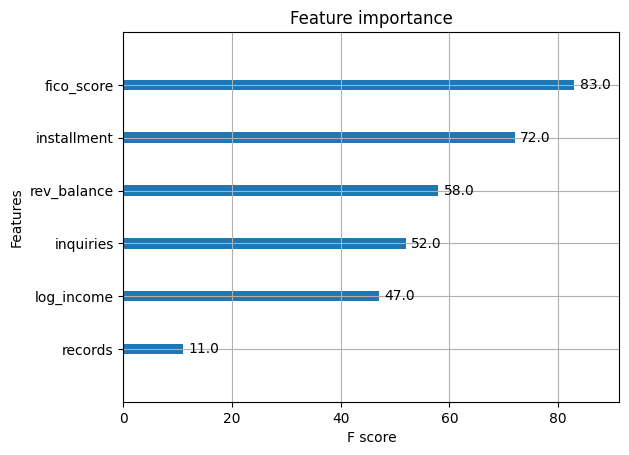

In [9]:
# Remember: The F score is based on how often a feature is used to split the data across all trees in the model, so this gives you a relative sense of importance, not causality.

xgboost.plot_importance(clf)

## Model Interpretation:



**1. Top Predictive Features:**

`fico_score` is by far the most important feature (F score: 83), suggesting that the model heavily relies on creditworthiness when predicting the target (or likely default).

`installment` (72) and `rev_balance` (58) are also strongly predictive — indicating that loan repayment terms and revolving balance significantly influence the model's decision-making.

**2. Moderately Important Features:**

`inquiries` (52) and `log_income` (47) contribute meaningfully, possibly capturing borrower activity and financial capability.

**3. Low Importance Feature:**

`records` (11) contributes very little to the model. This might mean it either has little variance or isn’t strongly correlated with default risk.